# `Промышленное машинное обучение на Spark`
## `Занятие 06: SparkML`

О чём можно узнать из этого ноутбука:

* Гистограммы в Spark
* Реализация ML Pipeline в Spark:
    1. Визуализация
    2. Предобработка
    3. Обучение модели
    4. Оценка качества

In [1]:
! pip3 install pyspark pyarrow seaborn wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=4302e4bc8ed6121f1dc93914c002b74b5f55bd582741880f526f01b0d8aa083c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

from pyspark import SparkConf, SparkContext

conf = (
    SparkConf()
        .set('spark.ui.port', '4050')
        .set('spark.driver.memory', '5g')
        .setMaster('local[*]')
)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

### `План анализа данных`

Как правило, для построения качественного ML-решения приходится проделывать следующие шаги:

1. Определение решаемой задачи
2. Загрузка данных
3. Визуализация данных и поиск в них инсайтов
4. Предобработка данных
5. Обучение модели на обучающей выборке
6. Оценка качества работы на тестовом множестве
7. Внедрение модели в некоторый продукт
   

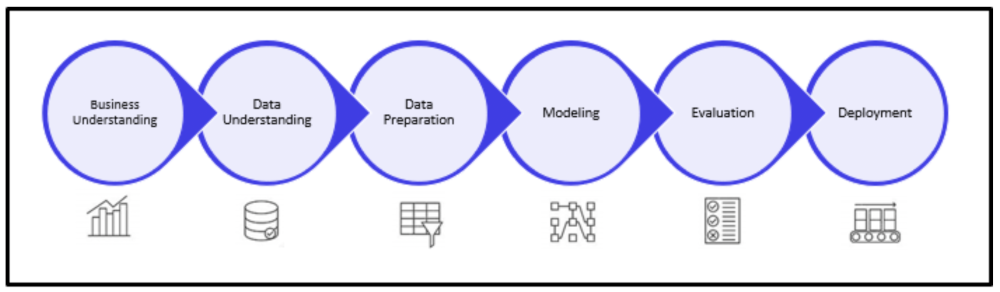

### `Шаг 1. Определение решаемой задачи`

В качестве модельного примера рассмотрим банковскую задачу - определение наступления дефолта физического лица по кредитной карте в следующем месяце. В качестве данных для эксперимента возьмём следующий [kaggle-датасет](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset). Данные для экперимента представляют собой исторические данные о платежах некоторого заёмщика в период с апреля по сентябрь 2005 года, а также некоторые сведения о самом заёмщике пол, возраст и тд.

### `Шаг 2. Загрузка данных`

Произведём скачивание данных из сети и загрузим их в Spark для дальнейших шагов пайплайна

In [4]:
import json
import os
import requests
import wget
import urllib.request
import zipfile


folder_url = 'https://disk.yandex.ru/d/Zmrxvz_g8ZyOpQ'
file_url = '/default-of-credit-card-clients-dataset.zip'

# запрос ссылки на скачивание
response = requests.get('https://cloud-api.yandex.net/v1/disk/public/resources/download',
                 params={'public_key': folder_url, 'path': file_url})

# 'парсинг' ссылки на скачивание
data_link = response.json()['href']

archive_filename = "default-of-credit-card.zip"
urllib.request.urlretrieve(data_link, archive_filename)


path = "default-of-credit-card"
with zipfile.ZipFile(archive_filename, 'r') as zip_ref:
    zip_ref.extractall(path)

os.remove(archive_filename)

In [13]:
!head $data_file

"ID","LIMIT_BAL","SEX","EDUCATION","MARRIAGE","AGE","PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6","PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6","default.payment.next.month"
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,5e+05,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,1e+05,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542

In [49]:
# Зададим пути к файлам из датасета
data_file = f"{path}/UCI_Credit_Card.csv"

file_type = "csv"
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

data = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(data_file)
)

In [50]:
data.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default.payment.next.month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|  20000.0|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|   3913.0|   3102.0|    689.0|      0.0|      0.0|      0.0|     0.0|   689.0|     0.0|     0.0|     0.0|     0.0|                         1|
|  2| 120000.0|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|   2682.0|   1725.0|   2682.0|   3272.0|  

### `Шаг 3. Визуализация данных и поиск в них инсайтов`

Представление данных в виде таблиц не (а особенно больших таблиц) достаточно тяжело воспринимается человеком. Для того, чтобы лучше понимать, как устроены данные, с которыми предстоит работать помогают различные способы визуализации. В зависимости от того, какого типа и значения имеющиеся данные, применяются различные способы их представления: гистограмы, распределния, температурные карты и тд.

Некоторые наиболее популярные способы визуализации:
- Line plots
- Histograms
- Box plots
- Scatter plots
- Treemaps
- Heat maps
- И ещё много чего

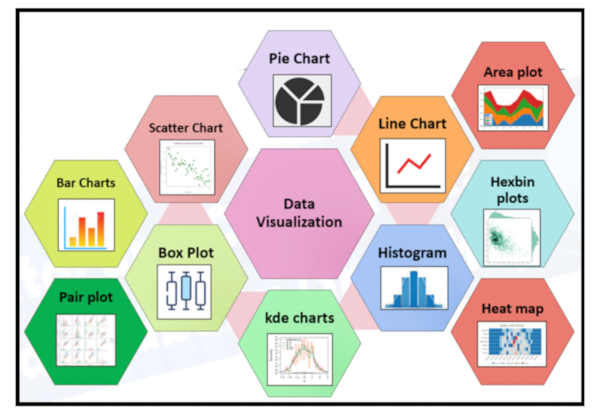

In [51]:
# переименуем целевую переменную в более компакную форму
data = data.withColumnRenamed('default.payment.next.month', 'IS_DEFAULT')
data.limit(10).toPandas()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,IS_DEFAULT
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,6,50000.0,1,1,2,37,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,7,500000.0,1,1,2,29,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
7,8,100000.0,2,2,2,23,0,-1,-1,0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
8,9,140000.0,2,3,1,28,0,0,2,0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0
9,10,20000.0,1,3,2,35,-2,-2,-2,-2,...,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0


##### `Доступные признаки`

Данные содержат три типа переменных:

* ID — индекс
* Целевая: **IS_DEFAULT**, наличие дефолта в сентябре
* Остальные переменные: $23$ переменных, могут быть использованы для прогноза целевой переменной.

---
| Имя столбца        | Значение |
| :-------------: |:-------------:|
| LIMIT_BAL   | Cумма предоставленного кредита |
| SEX | Пол (1 - мужской, 2 - женский) |
| EDUCATION | Уровень образования (1 - бакалавриат, 2 - Магистратура, 3 - Школа, 4 - Другое, 5 и 6 - нет данных) |
| MARRIAGE | Семейное положение (1 - в браке, 2 - одинок) |
| AGE | Возраст |
| PAY_6, ..., PAY2, PAY_0 | Статус погашения кредита с апреля по сентябрь (-1 - нет долгов, иное, # - задержка платежа на # месяцев)|
| BILL_AMT6, ..., BILL_AMT1 | Сумма на карте на расчетный период с апреля по август |
| PAY_AMT6, ..., PAY_AMT1 | Сумма предыдущего платежа c апреля по август |
| **IS_DEFAULT** | **Целевая переменная:** дефолт по кредитной карте в сентябре |
---

Так как все хранящиеся данные в SparkDataframe типизированые и определить их тип может сам Spark (параметр inferSchema=True при считывании файла). Можно для первоначального анализа посмотреть, какие типы у каждой из колонок

In [8]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: double (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: double (nullable = true)
 |-- BILL_AMT2: double (nullable = true)
 |-- BILL_AMT3: double (nullable = true)
 |-- BILL_AMT4: double (nullable = true)
 |-- BILL_AMT5: double (nullable = true)
 |-- BILL_AMT6: double (nullable = true)
 |-- PAY_AMT1: double (nullable = true)
 |-- PAY_AMT2: double (nullable = true)
 |-- PAY_AMT3: double (nullable = true)
 |-- PAY_AMT4: double (nullable = true)
 |-- PAY_AMT5: double (nullable = true)
 |-- PAY_AMT6: double (nullable = true)
 |-- IS_DEFAULT: integer (nullable = true)



In [52]:
data_test = data.withColumn("SEX", F.col("SEX").cast("double"))

In [15]:
data_test.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: double (nullable = true)
 |-- SEX: double (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: double (nullable = true)
 |-- BILL_AMT2: double (nullable = true)
 |-- BILL_AMT3: double (nullable = true)
 |-- BILL_AMT4: double (nullable = true)
 |-- BILL_AMT5: double (nullable = true)
 |-- BILL_AMT6: double (nullable = true)
 |-- PAY_AMT1: double (nullable = true)
 |-- PAY_AMT2: double (nullable = true)
 |-- PAY_AMT3: double (nullable = true)
 |-- PAY_AMT4: double (nullable = true)
 |-- PAY_AMT5: double (nullable = true)
 |-- PAY_AMT6: double (nullable = true)
 |-- IS_DEFAULT: integer (nullable = true)



In [16]:
data_test.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+----------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|IS_DEFAULT|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+----------+
|  1|  20000.0|2.0|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|   3913.0|   3102.0|    689.0|      0.0|      0.0|      0.0|     0.0|   689.0|     0.0|     0.0|     0.0|     0.0|         1|
|  2| 120000.0|2.0|        2|       2| 26|   -1|    2|    0|    0|    0|    2|   2682.0|   1725.0|   2682.0|   3272.0|   3455.0|   3261.0|     0.0|  1000.0|  1000.0|  1000.0|     0.0| 

Аналогично методу [.describe из Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) Spark предоставляет аналогичный [метод .summary](https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.DataFrame.summary.html) для подсчёта стандартных статистик по каждой колонки датафрейма

In [17]:
data.summary().toPandas()

,summary,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,IS_DEFAULT
0,count,30000,30000,30000,30000,30000,30000,30000,30000,30000,...,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
1,mean,15000.5,167484.32266666667,1.6037333333333332,1.8531333333333333,1.5518666666666667,35.4855,-0.0167,-0.13376666666666667,-0.1662,...,43262.94896666666,40311.40096666667,38871.7604,5663.5805,5921.1635,5225.6815,4826.076866666666,4799.387633333334,5215.502566666667,0.2212
2,stddev,8660.398374208891,129747.66156720246,0.4891291960902602,0.7903486597207269,0.5219696006132467,9.217904068090155,1.1238015279973335,1.1971859730345495,1.1968675684465686,...,64332.856133916444,60797.15577026471,59554.1075367459,16563.28035402577,23040.870402057186,17606.96146980311,15666.159744032062,15278.305679144742,17777.46577543531,0.41506180569093254
3,min,1,10000.0,1,0,0,21,-2,-2,-2,...,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,25%,7498,50000.0,1,1,1,28,-1,-1,-1,...,2320.0,1761.0,1255.0,1000.0,832.0,390.0,295.0,251.0,116.0,0
5,50%,14999,140000.0,2,2,2,34,0,0,0,...,19050.0,18101.0,17068.0,2100.0,2009.0,1800.0,1500.0,1500.0,1500.0,0
6,75%,22497,240000.0,2,2,2,41,0,0,0,...,54472.0,50170.0,49147.0,5006.0,5000.0,4503.0,4012.0,4030.0,4000.0,0
7,max,30000,1000000.0,2,6,3,79,8,8,8,...,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,1


Посчитаем для каждой колонки c ограниченным диапозоном значение

 Proccessed column SEX statistics
+---+-----+
|SEX|count|
+---+-----+
|  1|11888|
|  2|18112|
+---+-----+



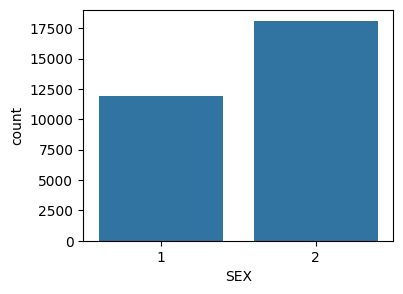

-------------------------------------
 Proccessed column EDUCATION statistics
+---------+-----+
|EDUCATION|count|
+---------+-----+
|        0|   14|
|        1|10585|
|        2|14030|
|        3| 4917|
|        4|  123|
|        5|  280|
|        6|   51|
+---------+-----+



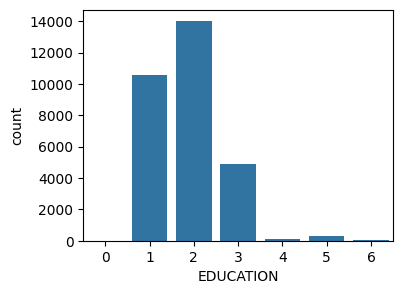

-------------------------------------
 Proccessed column MARRIAGE statistics
+--------+-----+
|MARRIAGE|count|
+--------+-----+
|       0|   54|
|       1|13659|
|       2|15964|
|       3|  323|
+--------+-----+



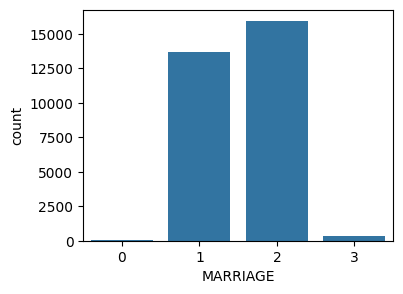

-------------------------------------
 Proccessed column PAY_0 statistics
+-----+-----+
|PAY_0|count|
+-----+-----+
|   -2| 2759|
|   -1| 5686|
|    0|14737|
|    1| 3688|
|    2| 2667|
|    3|  322|
|    4|   76|
|    5|   26|
|    6|   11|
|    7|    9|
|    8|   19|
+-----+-----+



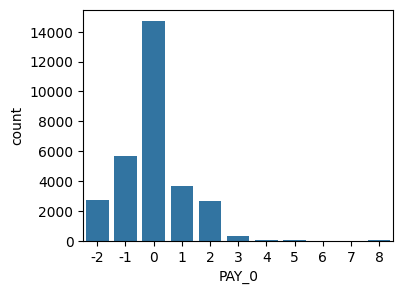

-------------------------------------
 Proccessed column PAY_2 statistics
+-----+-----+
|PAY_2|count|
+-----+-----+
|   -2| 3782|
|   -1| 6050|
|    0|15730|
|    1|   28|
|    2| 3927|
|    3|  326|
|    4|   99|
|    5|   25|
|    6|   12|
|    7|   20|
|    8|    1|
+-----+-----+



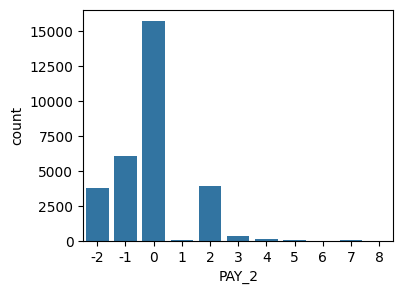

-------------------------------------
 Proccessed column PAY_3 statistics
+-----+-----+
|PAY_3|count|
+-----+-----+
|   -2| 4085|
|   -1| 5938|
|    0|15764|
|    1|    4|
|    2| 3819|
|    3|  240|
|    4|   76|
|    5|   21|
|    6|   23|
|    7|   27|
|    8|    3|
+-----+-----+



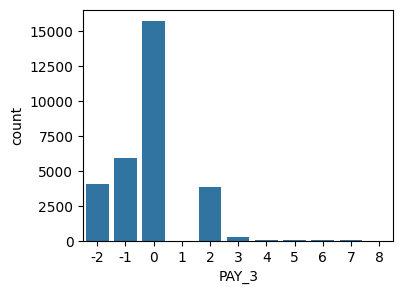

-------------------------------------
 Proccessed column PAY_4 statistics
+-----+-----+
|PAY_4|count|
+-----+-----+
|   -2| 4348|
|   -1| 5687|
|    0|16455|
|    1|    2|
|    2| 3159|
|    3|  180|
|    4|   69|
|    5|   35|
|    6|    5|
|    7|   58|
|    8|    2|
+-----+-----+



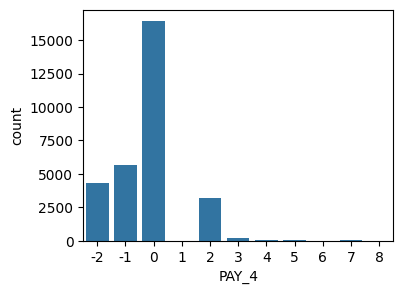

-------------------------------------
 Proccessed column PAY_5 statistics
+-----+-----+
|PAY_5|count|
+-----+-----+
|   -2| 4546|
|   -1| 5539|
|    0|16947|
|    2| 2626|
|    3|  178|
|    4|   84|
|    5|   17|
|    6|    4|
|    7|   58|
|    8|    1|
+-----+-----+



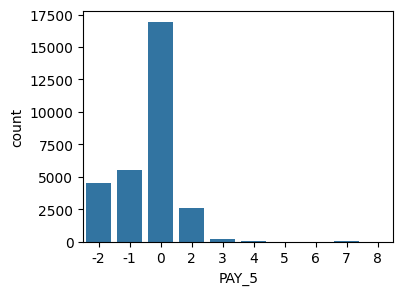

-------------------------------------
 Proccessed column PAY_6 statistics
+-----+-----+
|PAY_6|count|
+-----+-----+
|   -2| 4895|
|   -1| 5740|
|    0|16286|
|    2| 2766|
|    3|  184|
|    4|   49|
|    5|   13|
|    6|   19|
|    7|   46|
|    8|    2|
+-----+-----+



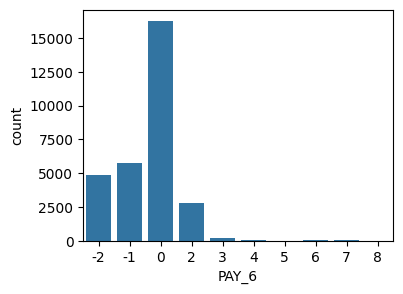

-------------------------------------
 Proccessed column IS_DEFAULT statistics
+----------+-----+
|IS_DEFAULT|count|
+----------+-----+
|         0|23364|
|         1| 6636|
+----------+-----+



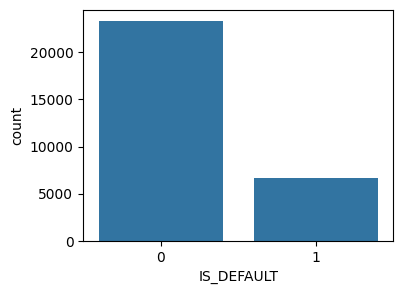

-------------------------------------


In [18]:
for column, dtype in data.dtypes:
    if column not in {'ID', 'AGE'} and dtype == 'int':
        print(f"\033[95m Proccessed column {column} statistics\033[0m")
        grouped_data = data.groupBy(column).count().orderBy(column)
        grouped_data.show()

        plt.figure(figsize=(4,3))
        ax = sns.barplot(grouped_data.toPandas(), x=column, y="count")
        plt.show()
        print("-------------------------------------")


##### `Построение гистограмм`

Есть $4$ основных варианта для визуализации данных в Spark:
1. Перевести данные в pandas.DataFrame и использовать стандартные приёмы
2. Использовать встроенные методы для вычисления нужных статистик и отрисовка их стандартными методами
3. Использование Pandas on Spark API (библиотека `HandySpark`)
4. Использование сторонних библиотек (см. `pyspark_dist_explore`)

In [19]:
! pip3 install pyspark_dist_explore

In [20]:
import pyspark_dist_explore

In [22]:
pay_0 = data.filter((data.IS_DEFAULT == 0) & (data.PAY_AMT1 > 0)).select(F.log10('PAY_AMT1'))
pay_1 = data.filter((data.IS_DEFAULT == 1) & (data.PAY_AMT1 > 0)).select(F.log10('PAY_AMT1'))

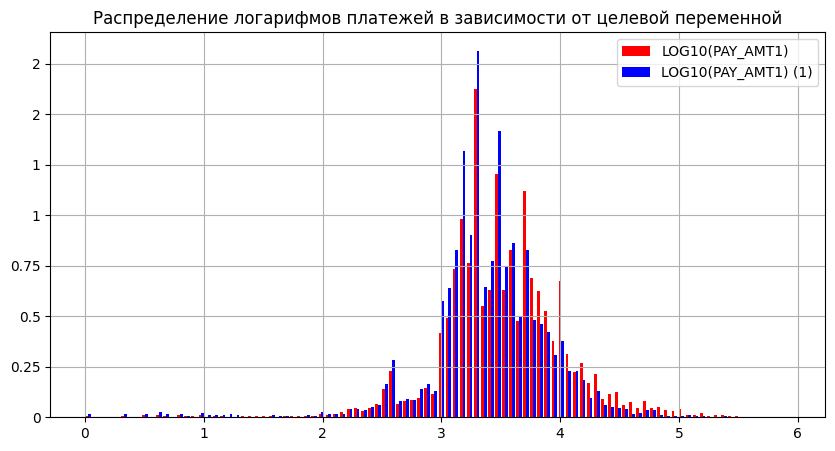

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

pyspark_dist_explore.hist(ax, [pay_0, pay_1], color=['red', 'blue'], bins=100, density=True)

ax.set_title('Распределение логарифмов платежей в зависимости от целевой переменной')
ax.grid(True)
ax.legend()
plt.show()
fig.tight_layout()
plt.show()

В примере выше построение гистограммы происходило через вызов сторонней библиотеки. Но у данного решения есть свои минусы - небольшое количество методов визуализации: hist и distplot.
Сейчас рассмотрим более классический способ построения данных в Spark: через подсчёт статистик на Spark, а саму визуализацию производить через pandas/numpy + matplotlib/seabron

Text(0.5, 23.52222222222222, 'AGE INTERVAL')

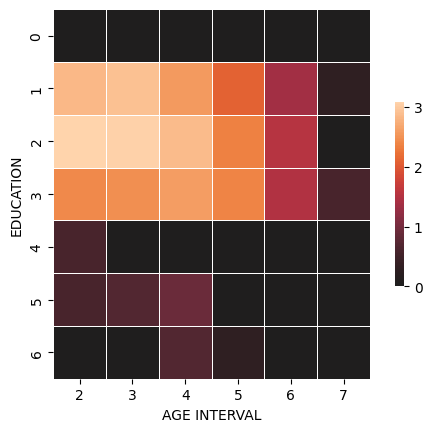

In [24]:
import seaborn as sns

data = data.withColumn("AGE_INTERVAL", F.floor(F.col("AGE") / 10) )

grouped_data = (
    data
    .groupBy("EDUCATION", "AGE_INTERVAL")
    .agg(
        F.sum("IS_DEFAULT").alias("NUM_DEFAULT")
    )
    .select(
        "EDUCATION", "AGE_INTERVAL", F.log10(F.col("NUM_DEFAULT")).alias("LOG_DEFAULT")
    )
)

grouped_data = (
    grouped_data
    .groupBy("EDUCATION")
    .pivot("AGE_INTERVAL")
    .agg(F.first("LOG_DEFAULT"))
    .orderBy("EDUCATION")
    .fillna(0)
)

grouped_data_pandas_df = grouped_data.toPandas().set_index("EDUCATION")


ax = sns.heatmap(grouped_data_pandas_df, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xlabel("AGE INTERVAL")

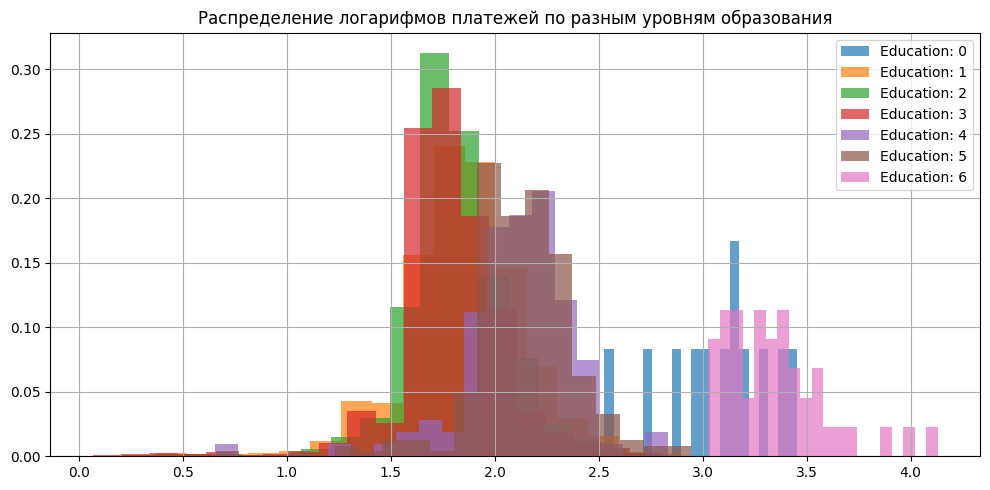

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ed_levels = data.select('EDUCATION').distinct().collect()
for ed_level, color in zip(sorted(ed_levels), plt.cm.tab10.colors):
    buckets, histogram = (
            data
            .filter(
                (data.EDUCATION == ed_level.EDUCATION) & (data.PAY_AMT1 > 0)
            )
            .select(F.log10('PAY_AMT1').alias('log_PAY_AMT1'))
            .rdd
            .map(lambda x: x.log_PAY_AMT1) # метод histogram работает только над численными rdd
            .histogram(20) # 20 - число корзин (столбцов) в гистограмме
    )

    buckets = np.array(buckets)
    histogram = np.array(histogram)

    # смещаем точку каждой корзины на центр
    buckets = (buckets[:-1] + buckets[1]) / 2
    # делим значение в каждой гистограмме на сумму, чтобы получить распределение
    histogram = histogram / np.sum(histogram)

    ax.bar(
        buckets,
        histogram,
        width=(buckets[1] - buckets[0]), label=f"Eduсation: {ed_level.EDUCATION}", alpha=0.7, color=color)

ax.set_title('Распределение логарифмов платежей по разным уровням образования')
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()

### `Шаг 4. Предобработка данных`

Как правило редко бывает так, чтобы исходные данные можно было взять as is и подать целиком на обучение в некоторый ML-алгоритм. Зачастую перед тем как подавать данные в алгоритм нужно произвести их предварительную предобработку:

 - Закодировать в численное представление не численные данные, например, строки
 - Заполнить или удалить строки содержащие пропущенные значения (Null) или Not A Number (NaN)
 - Преобразовать данные под специфический вход модели: [word2vec](https://serokell.io/blog/word2vec), [oneHotEncoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), [MeanEncoding](https://towardsdatascience.com/why-you-should-try-mean-encoding-17057262cd0)
 - Произвести нормализацию, логарифмирование и тд
 - Убрать DataLeaks
 - Поделить датасет на обучение и тест

In [53]:
data = data.drop('ID')
data_train, data_test = data.randomSplit([0.7, 0.3], seed=6417) # Разделение на обучающую и тестовую выборки

In [56]:
data_train.count(), data_test.count()

(20950, 9050)

In [55]:
data.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+----------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|IS_DEFAULT|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+----------+
|  20000.0|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|   3913.0|   3102.0|    689.0|      0.0|      0.0|      0.0|     0.0|   689.0|     0.0|     0.0|     0.0|     0.0|         1|
| 120000.0|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|   2682.0|   1725.0|   2682.0|   3272.0|   3455.0|   3261.0|     0.0|  1000.0|  1000.0|  1000.0|     0.0|  2000.0|         1|


In [27]:
from pyspark.ml import Pipeline

from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StandardScaler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

Pyspark имеет широкую поддержку различных способов обработки данных для различных типов данных и под различные модели.
Про существующие методы можно почитать здесь [здесь](https://spark.apache.org/docs/latest/ml-features.html)

Вся работа ML-алгоритмов происходит над признаковыми векторами, которые можно получаются вызововом специальных методов над исходными данными.

Некоторые из этих методов:
- VectorAssembler
- CountVectorizer
- OneHotEncoder

In [59]:
label_column = 'IS_DEFAULT'
feature_columns = [column for column in data.columns if column != label_column]

In [63]:
feature_columns

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [60]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features') # Сбор признаков в вектор
assembler

VectorAssembler_21feb0e4eb98

In [62]:
vectorized_data = assembler.transform(data)
vectorized_data.select("LIMIT_BAL", "SEX", "EDUCATION", F.lit("..."), "features").show(5, False)

+---------+---+---------+---+--------------------------------------------------------------------------------------------------------------------------------------------+
|LIMIT_BAL|SEX|EDUCATION|...|features                                                                                                                                    |
+---------+---+---------+---+--------------------------------------------------------------------------------------------------------------------------------------------+
|20000.0  |2  |2        |...|[20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0]                            |
|120000.0 |2  |2        |...|[120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0]          |
|90000.0  |2  |2        |...|[90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000

Теперь произведём нормализацию собранных векторов. Для этого воспользуемся классом StandardScaler.

In [64]:
scaler = StandardScaler(inputCol='features', outputCol='features_scaled', withMean=True, withStd=True) # Масштабирование признаков
scaler

StandardScaler_40548a9ca762

In [66]:
scalerModel = scaler.fit(vectorized_data)
scaled_data = scalerModel.transform(vectorized_data)
scaled_data.select("LIMIT_BAL", "SEX", "EDUCATION", F.lit("..."), "features", "features_scaled").show(5, False)

+---------+---+---------+---+--------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|LIMIT_BAL|SEX|EDUCATION|...|features                                                                                                                                    |features_scaled                                                                                                                                                                                

### `Шаг 5. Обучение модели на обучающей выборке`


Теперь всё готово, чтобы произвести обучение модели. Расммотрим задачу обучения на примере логистической и линейной модели

In [67]:
logistic_regressor = LogisticRegression(featuresCol='features_scaled', labelCol=label_column, predictionCol='prediction')
linear_regression = LinearRegression(featuresCol='features_scaled', labelCol=label_column, predictionCol='prediction_reg')

logistic_regressor, linear_regression

(LogisticRegression_b3a8b90a303d, LinearRegression_786af3e99352)

In [68]:
logistic_regressor_trained = logistic_regressor.fit(scaled_data)
predicted_data = logistic_regressor_trained.transform(scaled_data)
predicted_data.select(
    "LIMIT_BAL", "SEX", F.lit("..."),
    "features", "features_scaled", "rawPrediction",
    "probability", "prediction",
).show(5, False)

+---------+---+---+--------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------+----------------------------------------+----------+
|LIMIT_BAL|SEX|...|features                                                                                                                                    |features_scaled                                                                                                   

In [70]:
linear_regression_trained = linear_regression.fit(scaled_data)
predicted_data_linear = linear_regression_trained.transform(scaled_data)
predicted_data_linear.select(
    "LIMIT_BAL", "SEX", F.lit("..."),
    "features", "features_scaled", "prediction_reg"
).show(5, False)

+---------+---+---+--------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|LIMIT_BAL|SEX|...|features                                                                                                                                    |features_scaled                                                                                                                                                                                

In [71]:
# Ассемблер признаков
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Стандартизация
scaler = StandardScaler(inputCol='features', outputCol='features_scaled', withMean=True, withStd=True)

# Модель
logistic = LogisticRegression(featuresCol='features_scaled', labelCol=label_column, predictionCol='prediction')

# Pipeline
pipe = Pipeline(stages=[assembler, scaler, logistic])

# Обучение модели
pipe_model = pipe.fit(data_train)

In [72]:
print(pipe.stages)
print(pipe_model.stages)

Pipeline_1e8cb660e361__stages
[VectorAssembler_4fa6146861c9, StandardScalerModel: uid=StandardScaler_0083602ea1f8, numFeatures=23, withMean=true, withStd=true, LogisticRegressionModel: uid=LogisticRegression_62773a35850f, numClasses=2, numFeatures=23]


In [75]:
pipe_model.transform(data_train).limit(3).toPandas()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,IS_DEFAULT,features,features_scaled,rawPrediction,probability,prediction
0,10000.0,1,1,1,38,-1,-1,2,0,0,...,500.0,1100.0,0.0,1000.0,1,"[10000.0, 1.0, 1.0, 1.0, 38.0, -1.0, -1.0, 2.0...","[-1.2106245607528727, -1.2380925925385027, -1....","[1.3298376763226456, -1.3298376763226456]","[0.7908137832798223, 0.20918621672017768]",0.0
1,10000.0,1,1,1,40,2,-1,-1,-2,-2,...,0.0,0.0,0.0,0.0,1,"(10000.0, 1.0, 1.0, 1.0, 40.0, 2.0, -1.0, -1.0...","[-1.2106245607528727, -1.2380925925385027, -1....","[-0.03788615054280742, 0.03788615054280742]","[0.490529595124213, 0.509470404875787]",1.0
2,10000.0,1,1,1,42,4,3,2,2,2,...,2000.0,0.0,359.0,331.0,0,"[10000.0, 1.0, 1.0, 1.0, 42.0, 4.0, 3.0, 2.0, ...","[-1.2106245607528727, -1.2380925925385027, -1....","[-2.0617333213100726, 2.0617333213100726]","[0.11287215259402215, 0.8871278474059778]",1.0


In [76]:
pipe_model.transform(data_test).limit(3).toPandas()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,IS_DEFAULT,features,features_scaled,rawPrediction,probability,prediction
0,10000.0,1,1,1,41,0,0,3,2,2,...,0.0,1002.0,0.0,500.0,0,"[10000.0, 1.0, 1.0, 1.0, 41.0, 0.0, 0.0, 3.0, ...","[-1.2106245607528727, -1.2380925925385027, -1....","[0.45998406971605377, -0.45998406971605377]","[0.6130103970263817, 0.3869896029736183]",0.0
1,10000.0,1,1,2,22,0,0,0,0,0,...,300.0,1200.0,0.0,0.0,0,"[10000.0, 1.0, 1.0, 2.0, 22.0, 0.0, 0.0, 0.0, ...","[-1.2106245607528727, -1.2380925925385027, -1....","[1.0388219404346175, -1.0388219404346175]","[0.7386226347450514, 0.2613773652549486]",0.0
2,10000.0,1,1,2,22,2,2,2,0,0,...,1400.0,1100.0,0.0,500.0,1,"[10000.0, 1.0, 1.0, 2.0, 22.0, 2.0, 2.0, 2.0, ...","[-1.2106245607528727, -1.2380925925385027, -1....","[-0.42413278129271403, 0.42413278129271403]","[0.3955282360385519, 0.6044717639614481]",1.0


### `Оценка качества`

In [77]:
from pyspark.ml.classification import LogisticRegressionModel

# Поиск LogisticRegressionModel внутри pipe_model.stages
logistic_model = None
for stage in pipe_model.stages:
    if isinstance(stage, LogisticRegressionModel):
        logistic_model = stage
        break

# Проверка и вывод метрик
if logistic_model:
    summary = logistic_model.summary
    print("Accuracy:", summary.accuracy)
    print("Area Under ROC:", summary.areaUnderROC)
    print("Precision By Label:", summary.precisionByLabel)
    print("Recall By Label:", summary.recallByLabel)
else:
    print("LogisticRegressionModel not found in pipeline.")

Accuracy: 0.8085441527446301
Area Under ROC: 0.7236303702043676
Precision By Label: [0.8162098103874691, 0.7120622568093385]
Recall By Label: [0.9727356463002763, 0.23536977491961414]


In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [78]:
evaluator = BinaryClassificationEvaluator(
    labelCol=label_column,
    metricName='areaUnderROC'
)
print('ROC AUC train/test: {0:.3f}/{1:.3f}'.format(
    evaluator.evaluate(pipe_model.transform(data_train)),
    evaluator.evaluate(pipe_model.transform(data_test))
))

ROC AUC train/test: 0.724/0.726


### `Подбор гиперпараметров`

In [46]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [47]:
param_grid = (
    ParamGridBuilder()
        .addGrid(logistic_regressor.maxIter, [100])
        .addGrid(logistic_regressor.regParam, [1e-2, 1e-1, 1e-0, 1e-1])
        .addGrid(logistic_regressor.elasticNetParam, [0.0, 0.5, 1.0])
        .build()
)
len(param_grid), param_grid[0]

(12,
 {Param(parent='LogisticRegression_b04581fefc66', name='maxIter', doc='max number of iterations (>= 0).'): 100,
  Param(parent='LogisticRegression_b04581fefc66', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
  Param(parent='LogisticRegression_b04581fefc66', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})

In [48]:
tvs = TrainValidationSplit(
    estimator=pipe,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,
    seed=6417
)

tvs_model = tvs.fit(data)
tvs_model

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
print('ROC AUC train/test: {0:.3f}/{1:.3f}'.format(
    evaluator.evaluate(tvs_model.transform(data_train)),
    evaluator.evaluate(tvs_model.transform(data_test))
))

In [ ]:
tvs_model.bestModel.stages[-1].extractParamMap()

### `Пример. Random Forest`

In [ ]:
label_column = 'IS_DEFAULT'
feature_columns = [ column for column in data.columns
                   if column not in {label_column, 'EDUCATION'}]

In [ ]:
ohe_encoder = OneHotEncoder(inputCols=['EDUCATION'], outputCols=['EDUCATION_OHE'])
rf_assembler = VectorAssembler(inputCols=feature_columns + ['EDUCATION_OHE'], outputCol='features')
random_forest = RandomForestClassifier(featuresCol='features', labelCol=label_column, predictionCol='prediction')

rf_pipe = Pipeline(stages=[ohe_encoder, rf_assembler, random_forest])
ohe_encoder, rf_assembler, random_forest, rf_pipe

(OneHotEncoder_f4773eb54c32,
 VectorAssembler_08c9bd219ac5,
 RandomForestClassifier_535cfe794bfd,
 Pipeline_2e969e0267f7)

In [ ]:
rf_pipe_model = rf_pipe.fit(data_train)
rf_pipe_model.transform(data_train).limit(3).toPandas()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,IS_DEFAULT,EDUCATION_OHE,features,rawPrediction,probability,prediction
0,10000.0,1,1,1,38,-1,-1,2,0,0,...,500.0,1100.0,0.0,1000.0,1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","[10000.0, 1.0, 1.0, 38.0, -1.0, -1.0, 2.0, 0.0...","[15.115365767550237, 4.884634232449765]","[0.7557682883775118, 0.24423171162248822]",0.0
1,10000.0,1,1,1,40,2,-1,-1,-2,-2,...,0.0,0.0,0.0,0.0,1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(10000.0, 1.0, 1.0, 40.0, 2.0, -1.0, -1.0, -2....","[14.341543930044757, 5.65845606995524]","[0.717077196502238, 0.28292280349776205]",0.0
2,10000.0,1,1,1,42,4,3,2,2,2,...,2000.0,0.0,359.0,331.0,0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","[10000.0, 1.0, 1.0, 42.0, 4.0, 3.0, 2.0, 2.0, ...","[6.948231766721838, 13.051768233278166]","[0.3474115883360918, 0.6525884116639081]",1.0


In [ ]:
print(rf_pipe.stages)
print(rf_pipe_model.stages)

NameError: name 'rf_pipe' is not defined

In [ ]:
print('ROC AUC train/test: {0:.3f}/{1:.3f}'.format(
    evaluator.evaluate(rf_pipe_model.transform(data_train)),
    evaluator.evaluate(rf_pipe_model.transform(data_test))
))

ROC AUC train/test: 0.771/0.766


In [ ]:
rf_pipe_model.stages[-1]

RandomForestClassificationModel: uid=RandomForestClassifier_535cfe794bfd, numTrees=20, numClasses=2, numFeatures=28

### `Пример. Текстовые данные`

In [ ]:
path = './tweets'

! mkdir $path
! wget -O "$path/negative.csv" "https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0"
! wget -O "$path/positive.csv" "https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0"

--2023-02-23 21:43:13--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0
Распознаётся www.dropbox.com (www.dropbox.com)… 162.125.70.18
Подключение к www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: /s/raw/r6u59ljhhjdg6j0/negative.csv [переход]
--2023-02-23 21:43:13--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://uc458492ce8483231fcc51ab3159.dl.dropboxusercontent.com/cd/0/inline/B3C90EQlJSbFdof-Q4-HPt3AA7RI5i6oGPEH8xpYhj32UTwXAZr0AKaJgikEcP7hFrXCiq1U5WQfbMWyVMAdoqWDDXsBKnZKpKuYX6Kuy6-4GecvRh_Ldqmvxj5WPM7dgp8UroBMyz-6SewaeHA4QzO4_vUuhKNS-Dj2WUkwbsZPLw/file# [переход]
--2023-02-23 21:43:14--  https://uc458492ce8483231fcc51ab3159.dl.dropboxusercontent.com/cd/0/inline/B3C90EQlJSbFdof-Q4-HPt3AA7RI5i6oGPEH8xpYhj32UTwXAZr0AKaJgikEcP7hFrXCiq1U5WQfbMWyVMAdoqWDDXs

In [ ]:
# Зададим пути к файлам из датасета
file_type = "csv"
infer_schema = "false"
first_row_is_header = "false"
delimiter = ";"

text_data_negative = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load([
          f"{path}/negative.csv",
        ])
)
text_data_positive = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load([
          f"{path}/positive.csv"
        ])
)

In [ ]:
display(text_data_negative.limit(3).toPandas())
display(text_data_positive.limit(3).toPandas())

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0


,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0


In [ ]:
text_data_negative = text_data_negative.select('_c3').withColumnRenamed('_c3', 'text').withColumn('label', F.lit(0))
text_data_positive = text_data_positive.select('_c3').withColumnRenamed('_c3', 'text').withColumn('label', F.lit(1))
text_data = text_data_negative.union(text_data_positive).dropna()

text_data.sample(3e-5).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+-----+
|text                                                                                                                         |label|
+-----------------------------------------------------------------------------------------------------------------------------+-----+
|Обидеть любимого человечка, самого дорогого в жизни , не хотя этого - только я могу......((((((((((((((((((                  |0    |
|обычно самый шумный - я, а тут соседи,хм )                                                                                   |1    |
|@Black_Balzac только не сожги остаток своего и так безразмерного мозга. Добра тебе еще раз) Пока                             |1    |
|Так мило наблюдать за девушками, которые чистят свои автомобили. Так бережно, поглядывая на маникюр. ) Девушки, вы прекрасны!|1    |
|@samoilenko143 ты как буд-то в другом часовом поясе живешь) у

In [ ]:
from pyspark.ml.feature import Tokenizer, NGram, HashingTF, IDF
from pyspark.ml.classification import NaiveBayes

In [ ]:
text_pipe = Pipeline(stages=[
    Tokenizer(inputCol='text', outputCol='tokens'),
    NGram(inputCol='tokens', outputCol='ngrams', n=2),
    HashingTF(inputCol='ngrams', outputCol='tf'),
    IDF(inputCol='tf', outputCol='idf'),
    VectorAssembler(inputCols=['tf', 'idf'], outputCol='features'),
    NaiveBayes(featuresCol='features', labelCol='label')
])

In [ ]:
text_pipe_model = text_pipe.fit(text_data)

23/02/23 21:43:35 WARN DAGScheduler: Broadcasting large task binary with size 30.6 MiB


23/02/23 21:43:43 WARN DAGScheduler: Broadcasting large task binary with size 30.6 MiB


In [ ]:
text_pipe_model.transform(text_data).limit(3).toPandas()

23/02/23 21:43:45 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


,text,label,tokens,ngrams,tf,idf,features,rawPrediction,probability,prediction
0,на работе был полный пиддес :| и так каждое за...,0,"[на, работе, был, полный, пиддес, :|, и, так, ...","[на работе, работе был, был полный, полный пид...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1967.08547000446, -1985.1947238238504]","[0.9999999863462801, 1.3653719889781722e-08]",0.0
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,"[коллеги, сидят, рубятся, в, urban, terror,, а...","[коллеги сидят, сидят рубятся, рубятся в, в ur...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1536.899562052501, -1695.331439735471]","[1.0, 1.562822894282169e-69]",0.0
2,@elina_4post как говорят обещаного три года жд...,0,"[@elina_4post, как, говорят, обещаного, три, г...","[@elina_4post как, как говорят, говорят обещан...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-839.4052796735651, -857.270362723404]","[0.9999999825701759, 1.74298241347285e-08]",0.0


In [ ]:
evaluator_roc_auc = BinaryClassificationEvaluator(
    labelCol='label',
    metricName='areaUnderROC'
)
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='label',
    metricName='accuracy'
)
print('ROC AUC: {0:.3f}, Accuracy: {1:.3f}'.format(
    evaluator_roc_auc.evaluate(text_pipe_model.transform(text_data)),
    evaluator_accuracy.evaluate(text_pipe_model.transform(text_data)),
))

23/02/23 21:43:51 WARN DAGScheduler: Broadcasting large task binary with size 38.6 MiB


23/02/23 21:44:00 WARN DAGScheduler: Broadcasting large task binary with size 38.6 MiB


ROC AUC: 0.486, Accuracy: 0.849


### `Пример. Немного EDA для данных из проекта (M5 Forecasting)`

In [ ]:
path = "./m5-forecasting-accuracy"
! kaggle competitions download -c m5-forecasting-accuracy
! unzip m5-forecasting-accuracy.zip -d $path
! rm -rf m5-forecasting-accuracy.zip

 98%|█████████████████████████████████████▎| 45.0M/45.8M [00:02<00:00, 32.0MB/s]
100%|██████████████████████████████████████| 45.8M/45.8M [00:02<00:00, 21.1MB/s]
Archive:  m5-forecasting-accuracy.zip
  inflating: ./m5-forecasting-accuracy/calendar.csv  
  inflating: ./m5-forecasting-accuracy/sales_train_evaluation.csv  
  inflating: ./m5-forecasting-accuracy/sales_train_validation.csv  
  inflating: ./m5-forecasting-accuracy/sample_submission.csv  
  inflating: ./m5-forecasting-accuracy/sell_prices.csv  


In [ ]:
file_calendar = f"{path}/calendar.csv"
file_validation = f"{path}/sales_train_validation.csv"
file_evaluation = f"{path}/sales_train_evaluation.csv"
file_prices = f"{path}/sell_prices.csv"
file_calendar = f"{path}/calendar.csv"

file_type = "csv"
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df_validation = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(file_validation)
)
df_evaluation = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(file_evaluation)
)
df_prices = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(file_prices)
)
df_calendar = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(file_calendar)
)

In [ ]:
df_evaluation.limit(5).toPandas()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


Выясним, есть ли разница в спросе на товары в зависимости от дня недели. Для этого найдём суммарный спрос для каждого дня, затем проагрегируем его по дням недели и отобразим на графике.

Возьмём колонки, в которых содержится спрос в конкретный день:

In [ ]:
day_columns = [column for column in df_evaluation.columns if column.startswith('d_')]
day_columns[:10]

['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10']

Посчитаем суммарный спрос по всем товарам в каждый день:

In [ ]:
df_evaluation_agg = df_evaluation.select(
    *[
        F.sum(column).alias(column)
        for column in day_columns
    ]
).cache()

df_evaluation_agg.toPandas()

23/02/23 21:44:54 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB


23/02/23 21:45:04 WARN DAGScheduler: Broadcasting large task binary with size 1732.9 KiB


,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,32631,31749,23783,25412,19146,29211,28010,37932,32736,25572,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338


Чтобы выполнить агрегацию по дням недели нужно для каждого дня определить, какой день недели ему соответствует. Эта информация доступна в таблице с календарём:

In [ ]:
df_calendar.limit(10).toPandas()

/usr/local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,None,None,None,None,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,None,None,None,None,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,None,None,None,None,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,None,None,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,None,None,None,None,1,1,0


Чтобы добавить информацию о дне недели к информации о агрегированном спросе нужно транспонировать таблицу со спросом, а затем сделать join с календарём.

Выполним unpivot, сконструировав нужное выражение:

In [ ]:
column_exprs = []
for column in day_columns:
    column_exprs += [f'"{column}"', f'{column}']

unpivot_expr = 'stack({0}, {1}) as (Day, Count)'.format(
    len(column_exprs) // 2,
    ', '.join(column_exprs)
)
print(unpivot_expr[:60], '...', unpivot_expr[-71:])

stack(1941, "d_1", d_1, "d_2", d_2, "d_3", d_3, "d_4", d_4,  ... , "d_1939", d_1939, "d_1940", d_1940, "d_1941", d_1941) as (Day, Count)


In [ ]:
df_evaluation_agg_unpivot = df_evaluation_agg.select(F.expr(unpivot_expr)).cache()
df_evaluation_agg_unpivot.limit(10).toPandas()

23/02/23 21:45:16 WARN DAGScheduler: Broadcasting large task binary with size 1995.1 KiB


,Day,Count
0,d_1,32631
1,d_2,31749
2,d_3,23783
3,d_4,25412
4,d_5,19146
5,d_6,29211
6,d_7,28010
7,d_8,37932
8,d_9,32736
9,d_10,25572


Выполним join и оставим только нужные колонки:

In [ ]:
df_evaluation_agg_unpivot_with_wday = (
    df_evaluation_agg_unpivot
        .join(df_calendar, on=df_calendar.d == df_evaluation_agg_unpivot.Day)
        .select('Day', 'Count', 'weekday', 'wday')
).cache()
df_evaluation_agg_unpivot_with_wday.limit(5).toPandas()

23/02/23 21:45:21 WARN DAGScheduler: Broadcasting large task binary with size 2003.8 KiB


,Day,Count,weekday,wday
0,d_1,32631,Saturday,1
1,d_2,31749,Sunday,2
2,d_3,23783,Monday,3
3,d_4,25412,Tuesday,4
4,d_5,19146,Wednesday,5


Теперь проведём агрегацию по дням недели:

In [ ]:
count_per_weekday = (
    df_evaluation_agg_unpivot_with_wday
        .groupBy('weekday')
        .agg(
            F.sum('Count').alias('Count'),
            F.first('wday').alias('wday')
        )
        .collect()
)
count_per_weekday

23/02/23 21:45:25 WARN DAGScheduler: Broadcasting large task binary with size 2031.2 KiB


[Row(weekday='Saturday', Count=11594343, wday=1),
 Row(weekday='Sunday', Count=11482526, wday=2),
 Row(weekday='Monday', Count=9139596, wday=3),
 Row(weekday='Tuesday', Count=8448634, wday=4),
 Row(weekday='Wednesday', Count=8346126, wday=5),
 Row(weekday='Thursday', Count=8398928, wday=6),
 Row(weekday='Friday', Count=9517020, wday=7)]

Изобразим полученный спрос по дням недели на графике:

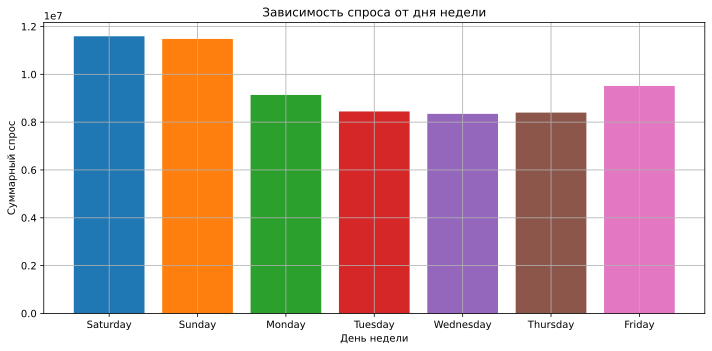

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for row in sorted(count_per_weekday, key=lambda row: row.wday):
    ax.bar(row.weekday, row.Count)

ax.grid(True)

ax.set_xlabel('День недели')
ax.set_ylabel('Суммарный спрос')
ax.set_title('Зависимость спроса от дня недели')

fig.tight_layout()
plt.show()

Исследуем месячный и годовой тренд выполнив агрегацию по месяцам и дням года:

In [ ]:
df_evaluation_agg_unpivot_with_date = (
    df_evaluation_agg_unpivot
        .join(df_calendar, on=df_calendar.d == df_evaluation_agg_unpivot.Day)
        .select('Day', 'Count', 'month', F.dayofyear('date').alias('day_of_year'))
).cache()
df_evaluation_agg_unpivot_with_date.limit(5).toPandas()

23/02/23 21:45:38 WARN DAGScheduler: Broadcasting large task binary with size 2004.2 KiB


,Day,Count,month,day_of_year
0,d_1,32631,1,29
1,d_2,31749,1,30
2,d_3,23783,1,31
3,d_4,25412,2,32
4,d_5,19146,2,33


In [ ]:
count_per_month = (
    df_evaluation_agg_unpivot_with_date
        .groupBy('month')
        .agg(F.mean('Count').alias('Count'))
        .collect()
)
count_per_month

23/02/23 21:45:40 WARN DAGScheduler: Broadcasting large task binary with size 2028.8 KiB


[Row(month=1, Count=33832.34810126582),
 Row(month=2, Count=34644.64117647059),
 Row(month=3, Count=34339.83870967742),
 Row(month=4, Count=34432.183333333334),
 Row(month=5, Count=34085.19209039548),
 Row(month=6, Count=35001.41333333333),
 Row(month=7, Count=35122.41935483871),
 Row(month=8, Count=35946.645161290326),
 Row(month=9, Count=35479.26),
 Row(month=10, Count=34713.47741935484),
 Row(month=11, Count=33290.82666666667),
 Row(month=12, Count=32980.46451612903)]

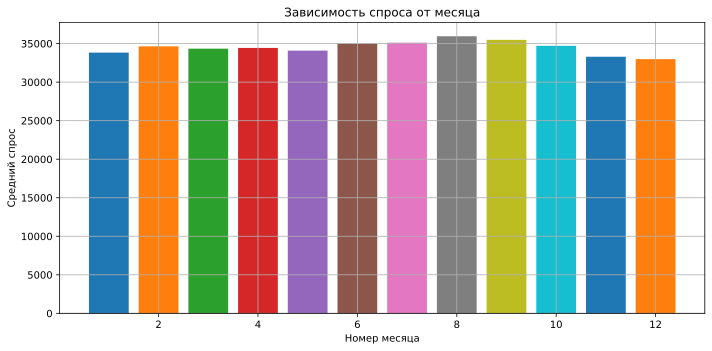

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for row in sorted(count_per_month, key=lambda row: row.month):
    ax.bar(row.month, row.Count)

ax.grid(True)

ax.set_xlabel('Номер месяца')
ax.set_ylabel('Средний спрос')
ax.set_title('Зависимость спроса от месяца')

fig.tight_layout()
plt.show()

In [ ]:
count_per_day = (
    df_evaluation_agg_unpivot_with_date
        .groupBy('day_of_year')
        .agg(
            F.mean('Count').alias('Count'),
            F.first('month').alias('month')
        )
        .collect()
)
count_per_day[:10]

23/02/23 21:45:44 WARN DAGScheduler: Broadcasting large task binary with size 2034.3 KiB


[Row(day_of_year=29, Count=30434.0, month=1),
 Row(day_of_year=30, Count=32336.833333333332, month=1),
 Row(day_of_year=31, Count=35634.333333333336, month=1),
 Row(day_of_year=32, Count=36961.833333333336, month=2),
 Row(day_of_year=33, Count=35437.333333333336, month=2),
 Row(day_of_year=34, Count=36652.0, month=2),
 Row(day_of_year=35, Count=33337.333333333336, month=2),
 Row(day_of_year=36, Count=36026.0, month=2),
 Row(day_of_year=37, Count=36598.666666666664, month=2),
 Row(day_of_year=38, Count=35893.833333333336, month=2)]

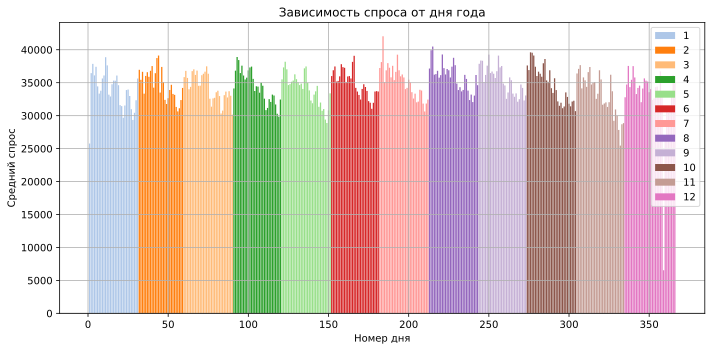

In [ ]:
import datetime

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for row in sorted(count_per_day, key=lambda row: row.day_of_year):
    is_the_first_day_of_month = (
        datetime.date(year=2000, month=1, day=1) +
        datetime.timedelta(days=row.day_of_year - 1) ==
        datetime.date(year=2000, month=row.month, day=1)
    )
    ax.bar(
        row.day_of_year, row.Count, color=plt.get_cmap('tab20')(row.month),
        label=f'{row.month}' if is_the_first_day_of_month else None
    )

ax.legend()
ax.grid(True)

ax.set_xlabel('Номер дня')
ax.set_ylabel('Средний спрос')
ax.set_title('Зависимость спроса от дня года')

fig.tight_layout()
plt.show()